In [1]:
import getpass

mypasswd = getpass.getpass()

········


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import psycopg2
import pandas as pd
import numpy as np
from psycopg2.extensions import adapt, register_adapter, AsIs

# Then connects to the DB
connection = psycopg2.connect(database = 'capstonesp23olt05', 
                              user = 'ajmvgd', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

cursor = connection.cursor()

In [3]:
del mypasswd

## Sub query for our main Model Building query. This uses Away Team data in the sub
    We are wanting to utilize a sub query to find each unique matchup for predicting whether or not a team will beat/lose to the spread

In [4]:
sub_query = f"""
SELECT P.game_id,P.team_name as away_team, P.gametime_day, 

R.point_differential as away_pt_diff


,R.passing_completion_percentage as away_pass_comp_pct
, R.passing_interception_percentage as away_pass_int_pct
, R.passing_qbr as away_qbr, R.passing_yards_per_attempt as away_pass_per_attempt, 
R.passing_net_yards_per_attempt as away_pass_net_yards_per_attempt
, R.rushing_first_downs_earned as away_rush_first_downs_earned, R.passing_first_downs_earned as away_passing_first_downs_earned,
R.third_down_conversions_percentage as away_third_downs_convs_pct,R.fourth_down_attempts as away_fourth_down_attempts, 
 R.rushing_yards_per_attempt as away_rush_yards_per_attempt,
R.offensive_yards_per_play as away_off_yards_per_play, R.defensive_yards_per_play as away_def_yards_per_play
,R.rushing_attempts as away_rush_attempts, R.punts as away_punts




       


FROM team_weekly_stats P
INNER JOIN team_weekly_stats_running R ON P.game_id=R.game_id
INNER JOIN game G ON P.game_id=G.game_id
INNER JOIN line L ON P.game_id=L.game_id

where P.home_or_away= 'away' AND R.home_or_away= 'away'  AND G.game_type <> 'SB'

AND R.gametime_week<>1
order by P.gametime_year,P.gametime_day,P.game_id

"""

## Joining the Away Team sub query with the Home Team data

In [5]:
big_query = f"""
SELECT P.game_id,P.team_name,P.gametime_year,P.gametime_week, P.gametime_day, SUB.away_team,
CASE WHEN P.win_or_loss= 'W' THEN '1' ELSE '0' END as win_class
, G.game_type, L.home_line_open, 
-1*(P.team_score-P.opponent_score) as spread_actual,

CASE WHEN  -1*(P.team_score-P.opponent_score)<L.home_line_open THEN '0' ELSE '1' END as home_lose_spread,
R.point_differential as home_pt_diff,
R.passing_completion_percentage, R.passing_interception_percentage, R.passing_qbr, R.passing_yards_per_attempt, 
R.passing_net_yards_per_attempt, R.rushing_first_downs_earned, R.passing_first_downs_earned,
R.third_down_conversions_percentage,R.fourth_down_attempts, 
R.penalties_committed_yards,R.opponent_penalties_committed_yards, R.rushing_yards_per_attempt,
R.offensive_yards_per_play, R.defensive_yards_per_play,R.punts as home_punts, R.rushing_attempts as home_rush_attempts




 







,SUB.away_pass_comp_pct,SUB.away_pass_int_pct,SUB.away_qbr,SUB.away_pass_per_attempt,SUB.away_pass_net_yards_per_attempt
,SUB.away_rush_first_downs_earned,SUB.away_passing_first_downs_earned,SUB.away_third_downs_convs_pct
,SUB.away_fourth_down_attempts
,SUB.away_rush_yards_per_attempt,SUB.away_off_yards_per_play,SUB.away_def_yards_per_play
,SUB.away_punts,SUB.away_rush_attempts,SUB.away_pt_diff













FROM team_weekly_stats P
INNER JOIN team_weekly_stats_running R ON P.game_id=R.game_id
INNER JOIN game G ON P.game_id=G.game_id
INNER JOIN line L ON P.game_id=L.game_id


INNER JOIN ({sub_query}  ) SUB ON P.game_id=SUB.game_id
where P.home_or_away= 'home' AND R.home_or_away= 'home'  AND G.game_type <> 'SUB'

AND R.gametime_week<>1
order by P.gametime_year,P.gametime_day,P.game_id
"""

sql_df_3 = pd.read_sql_query(big_query, con=connection)
mod_df = sql_df_3.copy()
mod_df.tail()

,game_id,team_name,gametime_year,gametime_week,gametime_day,away_team,win_class,game_type,home_line_open,spread_actual,...,away_rush_first_downs_earned,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_rush_yards_per_attempt,away_off_yards_per_play,away_def_yards_per_play,away_punts,away_rush_attempts,away_pt_diff
2030,2022_19_DAL_TB,Tampa Bay Buccaneers,2022,19,2023-01-16,Dallas Cowboys,0,WC,3.0,17,...,7.588235,11.411765,45.770588,1.117647,4.323529,5.418824,5.090588,4.000000,31.235294,125.0
2031,2022_20_JAX_KC,Kansas City Chiefs,2022,20,2023-01-21,Jacksonville Jaguars,1,DIV,-9.0,-7,...,6.611111,12.555556,40.127778,1.666667,4.716667,5.623889,5.361667,3.388889,26.055556,55.0
2032,2022_20_NYG_PHI,Philadelphia Eagles,2022,20,2023-01-21,New York Giants,1,DIV,-7.0,-31,...,8.944444,10.277778,37.761111,1.277778,4.844444,5.281111,5.677222,4.277778,30.555556,1.0
2033,2022_20_CIN_BUF,Buffalo Bills,2022,20,2023-01-22,Cincinnati Bengals,0,DIV,-4.0,17,...,5.941176,13.647059,47.082353,0.705882,3.717647,5.416471,5.407647,3.647059,24.529412,103.0
2034,2022_20_DAL_SF,San Francisco 49ers,2022,20,2023-01-22,Dallas Cowboys,1,DIV,-4.0,-7,...,7.611111,11.666667,46.216667,1.166667,4.288889,5.460000,5.076111,4.000000,31.444444,142.0


In [6]:
#drop duplicates
print(mod_df.shape)
mod_df.drop_duplicates(inplace=True)
print(mod_df.shape)

(2035, 43)
(2035, 43)


In [7]:
#print out any nulls present in columns
nulls = mod_df.isnull().sum(axis = 0)
nulls

game_id                               0
team_name                             0
gametime_year                         0
gametime_week                         0
gametime_day                          0
away_team                             0
win_class                             0
game_type                             0
home_line_open                        0
spread_actual                         0
home_lose_spread                      0
home_pt_diff                          1
passing_completion_percentage         1
passing_interception_percentage       1
passing_qbr                           1
passing_yards_per_attempt             1
passing_net_yards_per_attempt         1
rushing_first_downs_earned            1
passing_first_downs_earned            1
third_down_conversions_percentage     1
fourth_down_attempts                  1
penalties_committed_yards             1
opponent_penalties_committed_yards    1
rushing_yards_per_attempt             1
offensive_yards_per_play              1


In [8]:
#Drop Nulls
print(mod_df.shape)
mod_df.dropna(inplace=True)
print(mod_df.shape)
print(mod_df.groupby('home_lose_spread').size())

(2035, 43)
(2033, 43)
home_lose_spread
0     962
1    1071
dtype: int64


In [9]:
#getting home team and away team names for one-hot encoding team names
home_team_names = mod_df['team_name']
away_team_names = mod_df['away_team']

In [10]:
# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in columns associated with team names. 
mod_df['team_name']= label_encoder.fit_transform(mod_df['team_name']) 
mod_df['away_team']= label_encoder.fit_transform(mod_df['away_team']) 
mod_df.head()

,game_id,team_name,gametime_year,gametime_week,gametime_day,away_team,win_class,game_type,home_line_open,spread_actual,...,away_rush_first_downs_earned,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_rush_yards_per_attempt,away_off_yards_per_play,away_def_yards_per_play,away_punts,away_rush_attempts,away_pt_diff
0,2015_02_DEN_KC,15,2015,2,2015-09-17,9,0,REG,-3.0,7,...,4.0,11.0,44.4,0.0,2.8,3.17,3.04,5.0,25.0,6.0
1,2015_02_ARI_CHI,5,2015,2,2015-09-20,0,0,REG,1.5,25,...,7.0,13.0,50.0,0.0,4.8,7.49,5.83,4.0,25.0,12.0
2,2015_02_ATL_NYG,23,2015,2,2015-09-20,1,0,REG,-2.0,4,...,3.0,16.0,28.6,0.0,3.0,5.64,5.87,4.0,35.0,2.0
3,2015_02_BAL_OAK,16,2015,2,2015-09-20,2,1,REG,6.0,-4,...,6.0,4.0,15.4,1.0,3.2,3.04,3.17,6.0,23.0,-6.0
4,2015_02_DAL_PHI,25,2015,2,2015-09-20,8,0,REG,-5.5,10,...,4.0,21.0,54.5,0.0,3.5,6.41,4.72,2.0,23.0,1.0


In [11]:
#gather data for model training
Xsa=mod_df[['passing_completion_percentage', 'passing_interception_percentage',
       'passing_qbr', 
       'passing_net_yards_per_attempt', 'rushing_first_downs_earned',
       'passing_first_downs_earned', 'third_down_conversions_percentage',
       'fourth_down_attempts', 
       'penalties_committed_yards', 'opponent_penalties_committed_yards',
       'rushing_yards_per_attempt', 'offensive_yards_per_play',
       'defensive_yards_per_play'
       ,'away_pass_comp_pct', 'away_pass_int_pct', 'away_qbr',
       'away_pass_per_attempt', 'away_pass_net_yards_per_attempt',
       'away_rush_first_downs_earned', 'away_passing_first_downs_earned',
       'away_third_downs_convs_pct', 'away_fourth_down_attempts',
       'away_rush_yards_per_attempt', 'away_off_yards_per_play',
       'away_def_yards_per_play'
        ,'away_pt_diff'  ,'home_pt_diff'              ,'away_rush_attempts','away_punts','home_rush_attempts','home_punts'
           ,'away_team','team_name'
           ,'gametime_year','gametime_week'
                              
          
          ]]

y_spread=mod_df[['home_lose_spread','gametime_year','gametime_week']]#.astype('int').values
#y_spread=mod_df[['win_class','gametime_year','gametime_week']]#.astype('int').values

In [12]:
# new shape of dataframe
Xsa.shape

(2033, 35)

In [13]:
# Look for negative values that will need addressed for selectKbest
(Xsa<0).sum()

passing_completion_percentage            0
passing_interception_percentage          0
passing_qbr                              0
passing_net_yards_per_attempt            0
rushing_first_downs_earned               0
passing_first_downs_earned               0
third_down_conversions_percentage        0
fourth_down_attempts                     0
penalties_committed_yards                0
opponent_penalties_committed_yards       0
rushing_yards_per_attempt                0
offensive_yards_per_play                 0
defensive_yards_per_play                 0
away_pass_comp_pct                       0
away_pass_int_pct                        0
away_qbr                                 0
away_pass_per_attempt                    0
away_pass_net_yards_per_attempt          0
away_rush_first_downs_earned             0
away_passing_first_downs_earned          0
away_third_downs_convs_pct               0
away_fourth_down_attempts                0
away_rush_yards_per_attempt              0
away_off_ya

In [14]:
#show what values aren't being used in training that were in original query
mod_df.columns.difference(Xsa.columns).tolist()

['game_id',
 'game_type',
 'gametime_day',
 'home_line_open',
 'home_lose_spread',
 'passing_yards_per_attempt',
 'spread_actual',
 'win_class']

## Correlation Matrix to drop highly correlated features

In [15]:
corr = Xsa.corr()
corr

,passing_completion_percentage,passing_interception_percentage,passing_qbr,passing_net_yards_per_attempt,rushing_first_downs_earned,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,...,away_pt_diff,home_pt_diff,away_rush_attempts,away_punts,home_rush_attempts,home_punts,away_team,team_name,gametime_year,gametime_week
passing_completion_percentage,1.000000,-0.396161,0.755895,0.580701,0.165025,0.421688,0.404547,-0.096834,-0.027457,-0.126469,...,0.048135,0.303319,0.039001,-0.058613,0.061168,-0.469975,-0.016194,0.090740,0.124276,-0.020852
passing_interception_percentage,-0.396161,1.000000,-0.662050,-0.337660,-0.139908,-0.253594,-0.239099,0.037792,-0.045105,0.009009,...,-0.003340,-0.324495,0.002520,0.022526,-0.117168,0.135093,-0.012506,-0.042475,-0.015559,-0.030104
passing_qbr,0.755895,-0.662050,1.000000,0.798376,0.229316,0.463036,0.496116,-0.236336,0.013532,-0.033337,...,0.034902,0.485256,0.004069,-0.032983,0.200780,-0.438043,-0.018870,0.074846,0.038343,0.022310
passing_net_yards_per_attempt,0.580701,-0.337660,0.798376,1.000000,0.224109,0.504501,0.500823,-0.294078,0.066298,-0.029747,...,0.050765,0.461432,0.018570,0.020403,0.230045,-0.527757,-0.041808,0.056621,-0.044017,-0.001248
rushing_first_downs_earned,0.165025,-0.139908,0.229316,0.224109,1.000000,-0.118522,0.378393,0.068469,-0.104202,-0.165279,...,0.025987,0.375324,0.014545,-0.082168,0.765860,-0.426027,0.025932,-0.130872,0.214303,0.082068
passing_first_downs_earned,0.421688,-0.253594,0.463036,0.504501,-0.118522,1.000000,0.466717,-0.017696,0.030810,-0.002829,...,0.051159,0.233601,0.032319,-0.006510,-0.201965,-0.416970,-0.014396,0.016631,-0.036739,-0.007964
third_down_conversions_percentage,0.404547,-0.239099,0.496116,0.500823,0.378393,0.466717,1.000000,-0.197006,-0.051539,-0.075645,...,0.057479,0.377005,0.018129,0.007489,0.322615,-0.634658,0.020972,-0.025283,0.076279,0.021202
fourth_down_attempts,-0.096834,0.037792,-0.236336,-0.294078,0.068469,-0.017696,-0.197006,1.000000,-0.120749,-0.131120,...,-0.022468,-0.228600,0.014909,-0.106610,-0.087974,-0.139977,0.005027,-0.102686,0.316181,0.038836
penalties_committed_yards,-0.027457,-0.045105,0.013532,0.066298,-0.104202,0.030810,-0.051539,-0.120749,1.000000,0.231077,...,0.010828,-0.022073,0.039061,0.095986,-0.062666,0.167167,0.002353,0.011466,-0.269180,-0.131079
opponent_penalties_committed_yards,-0.126469,0.009009,-0.033337,-0.029747,-0.165279,-0.002829,-0.075645,-0.131120,0.231077,1.000000,...,-0.030485,-0.037183,-0.020164,0.121209,-0.095425,0.133637,-0.017363,0.005905,-0.279895,-0.104146


In [16]:
# Heat Map of Correlations
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [17]:
# Drop features that have correlation factor > 0.7
import numpy as np
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.7).any()
#m.to_csv('highly_corr_test_ajmvgd_cross_val.csv')
m

passing_completion_percentage         False
passing_interception_percentage        True
passing_qbr                           False
passing_net_yards_per_attempt         False
rushing_first_downs_earned            False
passing_first_downs_earned             True
third_down_conversions_percentage      True
fourth_down_attempts                   True
penalties_committed_yards              True
opponent_penalties_committed_yards     True
rushing_yards_per_attempt              True
offensive_yards_per_play              False
defensive_yards_per_play               True
away_pass_comp_pct                    False
away_pass_int_pct                      True
away_qbr                              False
away_pass_per_attempt                 False
away_pass_net_yards_per_attempt       False
away_rush_first_downs_earned          False
away_passing_first_downs_earned        True
away_third_downs_convs_pct             True
away_fourth_down_attempts              True
away_rush_yards_per_attempt     

In [18]:
# Correlation Matrix of data that is left
raw = corr.loc[m, m]
raw

,passing_interception_percentage,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,defensive_yards_per_play,away_pass_int_pct,away_passing_first_downs_earned,...,away_rush_yards_per_attempt,away_def_yards_per_play,away_pt_diff,home_pt_diff,away_punts,home_punts,away_team,team_name,gametime_year,gametime_week
passing_interception_percentage,1.000000,-0.253594,-0.239099,0.037792,-0.045105,0.009009,-0.057978,-0.074435,-0.007339,0.008328,...,0.001476,0.014206,-0.003340,-0.324495,0.022526,0.135093,-0.012506,-0.042475,-0.015559,-0.030104
passing_first_downs_earned,-0.253594,1.000000,0.466717,-0.017696,0.030810,-0.002829,-0.098764,0.217449,-0.008951,0.026142,...,0.016618,-0.026892,0.051159,0.233601,-0.006510,-0.416970,-0.014396,0.016631,-0.036739,-0.007964
third_down_conversions_percentage,-0.239099,0.466717,1.000000,-0.197006,-0.051539,-0.075645,0.127739,0.072292,-0.091205,0.014834,...,-0.012195,-0.001544,0.057479,0.377005,0.007489,-0.634658,0.020972,-0.025283,0.076279,0.021202
fourth_down_attempts,0.037792,-0.017696,-0.197006,1.000000,-0.120749,-0.131120,0.088242,0.132300,0.037130,0.011889,...,0.056239,0.046871,-0.022468,-0.228600,-0.106610,-0.139977,0.005027,-0.102686,0.316181,0.038836
penalties_committed_yards,-0.045105,0.030810,-0.051539,-0.120749,1.000000,0.231077,0.035029,-0.074567,-0.045651,0.027937,...,-0.076097,-0.041935,0.010828,-0.022073,0.095986,0.167167,0.002353,0.011466,-0.269180,-0.131079
opponent_penalties_committed_yards,0.009009,-0.002829,-0.075645,-0.131120,0.231077,1.000000,-0.127870,0.031341,-0.039407,-0.016398,...,-0.000960,0.013515,-0.030485,-0.037183,0.121209,0.133637,-0.017363,0.005905,-0.279895,-0.104146
rushing_yards_per_attempt,-0.057978,-0.098764,0.127739,0.088242,0.035029,-0.127870,1.000000,0.096229,0.002062,-0.015620,...,0.013686,-0.010323,0.003649,0.178307,-0.056098,-0.302306,0.026122,-0.115326,0.195610,0.034948
defensive_yards_per_play,-0.074435,0.217449,0.072292,0.132300,-0.074567,0.031341,0.096229,1.000000,0.044536,-0.016466,...,-0.014264,-0.019391,-0.011977,-0.314213,0.029562,-0.187580,-0.059103,0.055607,0.023381,-0.055985
away_pass_int_pct,-0.007339,-0.008951,-0.091205,0.037130,-0.045651,-0.039407,0.002062,0.044536,1.000000,-0.225824,...,-0.058052,-0.072032,-0.315759,-0.035595,0.109065,0.076761,-0.050922,-0.004358,-0.023622,-0.004262
away_passing_first_downs_earned,0.008328,0.026142,0.014834,0.011889,0.027937,-0.016398,-0.015620,-0.016466,-0.225824,1.000000,...,-0.133501,0.226991,0.207992,-0.002721,-0.411953,0.007201,-0.001370,-0.016198,-0.049721,-0.073282


In [19]:
#Updated training features dataset after correlation matrix and dropping highly correlated features
Xs = Xsa[['passing_interception_percentage', 'passing_first_downs_earned',
       'third_down_conversions_percentage', 'fourth_down_attempts',
       'penalties_committed_yards', 'opponent_penalties_committed_yards',
       'rushing_yards_per_attempt', 'defensive_yards_per_play',
       'away_pass_int_pct', 'away_passing_first_downs_earned',
       'away_third_downs_convs_pct', 'away_fourth_down_attempts',
       'away_rush_yards_per_attempt', 'away_def_yards_per_play',
       'away_pt_diff', 'home_pt_diff', 'away_punts', 'home_punts', 'away_team',
       'team_name', 'gametime_year', 'gametime_week' 
         ]]

# tried adding a few more features after seeing corr plot drops every high correlated feature and doesn't leave behind
# any of them that may have been left by themselves.
# ,'passing_completion_percentage','passing_net_yards_per_attempt','rushing_first_downs_earned'
#         ,'away_pass_comp_pct','away_pass_net_yards_per_attempt'

## want to use iteration and storage for model prediction scenarios

In [20]:
# This is main function definition for iterative modeling practice that our models are centered around
def year_split(year,week):
    X_train = Xs.loc[(Xs['gametime_week'] < week) & (Xs['gametime_year'] == year) & (Xs['gametime_week'] !=1)].drop(columns=['gametime_year','gametime_week'],axis=1)
    X_test = Xs.loc[(Xs['gametime_week'] == week) & (Xs['gametime_year'] == year) & (Xs['gametime_week'] !=1 )].drop(columns=['gametime_year','gametime_week'],axis=1)
    y_train = y_spread.loc[(y_spread['gametime_week'] < week) & (y_spread['gametime_year']==year) & (y_spread['gametime_week'] !=1 )].drop(columns=['gametime_year','gametime_week'],axis=1).astype('int').values
    y_test = y_spread.loc[(y_spread['gametime_week'] == week) & (y_spread['gametime_year']==year) & (y_spread['gametime_week'] !=1 )].drop(columns=['gametime_year','gametime_week'],axis=1).astype('int').values
    return X_train,X_test,y_train,y_test

## Utilizing MinMaxScaler for values that contain negatives so it won't flag error for SelectKBest

In [21]:

from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RepeatedStratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB


scaler = MinMaxScaler()

Xs[['away_pt_diff'  ,'home_pt_diff' ]] = scaler.fit_transform(Xs[['away_pt_diff'  ,'home_pt_diff'                              
                                                                ]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Temporary Dataframe for holding iterative modeling results

In [23]:
df = pd.DataFrame({
                    'Season':[2014]
                 ,'Week' : [7]
                  ,'Away_Team':['away_team']
                  ,'Home_Team':['team_name']
                  ,'Home_Team_Lost_Spread':['home_team_lose_spread']
                  ,'Prediction_Class':['pred_agg']
                  ,'Model_Probability':['home_prob_agg']
                  #, 'Var_Smoothing': ['var_smoothing']
})
df.explode('Away_Team')               
df.head()

,Season,Week,Away_Team,Home_Team,Home_Team_Lost_Spread,Prediction_Class,Model_Probability
0,2014,7,away_team,team_name,home_team_lose_spread,pred_agg,home_prob_agg


## Temporary Dataframe for Heat Map of Features Counter

In [24]:
feats_df = pd.DataFrame({
    'feat1': ['test']
    ,'feat2' : ['test']
    ,'feat3' : ['test']
    ,'feat4' : ['test']
    ,'feat5' : ['test']
    ,'feat6' : ['test']
    ,'feat7' : ['test']
    ,'feat8' : ['test']
    ,'feat9' : ['test']
    ,'feat10' : ['test']
    ,'feat11' : ['test']
    ,'feat12' : ['test']
})

## Train/Test Split Strategy

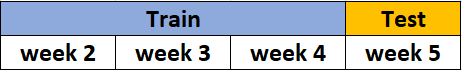

## Cross Validation Strategy

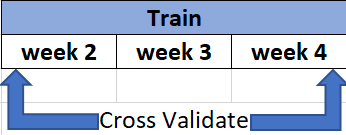

In [25]:
# Main modeling loop for each individual week that looks at previous data from that same season and uses it as training for
# leading up to that week, which will be the testing week.

#for 2022 NFL season
for i in range(2022,2023):
    # For all weeks in the season
    for j in range(3,21):
        
            
        #run function with iterative season splitting per week    
        test = year_split(i,j) 
        #store outputs from function
        X_train = test[0]
        X_test = test[1]
        y_train = test[2]
        y_test = test[3]
        #Using the X^2 feature selection on top 12 features
        k=12    
        selector = SelectKBest(chi2, k=k)
       
        #Fitting the selector to the training set
        
        print(X_train.shape)
        selector.fit(X_train, y_train)
        #print selected column names from selector
        print("Selected column names:",[X_train.columns[jj] for jj in selector.get_support(True)])
        
        # strong features preparation for dataframe
        xlist = []               
        for kk in selector.get_support(True):
            xlist.append(X_train.columns[kk])
        feats_df.loc[len(feats_df)] = xlist
        
        # Use selector from top 12 features to transform training and testing data
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)
        
        #using cross validation here. Fold strategy is Repeated Stratified K fold
        skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=1)
        # the parameter that we are optimizing is var_smoothing, which aims to make our data more into a normal distribution
        params = {'var_smoothing': np.logspace(0,-9, num=50)}
        #using Gaussian Naive Bayes for modeling because of distributive nature of our data.
        nb = GaussianNB()
        #grid search with cross validation for training set data ONLY. We can't use testing data because that would be using
        # future games to predict past games, which is not a real-world production scenario.
        model = GridSearchCV(nb, cv=skf, param_grid=params, 
                        verbose=1, 
                     scoring='accuracy')
            
        nbs = model.fit(X_train_selected, y_train.ravel())
        #out put info about modeling and testing data and the best smoothing parameter per week.
        print(f"{i}-Week {j}- # of k-best {k} ")
        print(model.best_params_)
        sss = model.best_params_
        
        #start putting model outputs into the dataframe for storage.
        X_test_df = pd.DataFrame(X_test_selected) 
        y_test_df = pd.DataFrame(y_test) 
        X_test_df['Home_Team_Lost_Spread'] = y_test
            
       
            
        y_predict_win_loss = nbs.predict(X_test_df.drop(columns=['Home_Team_Lost_Spread'],axis=1))
        X_test_df["Prediction_Class"]=y_predict_win_loss
        X_test_df['Model_Probability']=nbs.predict_proba(X_test_df.drop(columns=['Home_Team_Lost_Spread','Prediction_Class'],axis=1))[:,1]
        X_test_df['Model_Probability'] = X_test_df['Model_Probability'].astype('float')
        # put label inverses back into dataframe so we can see actual team names when evaluating results
        X_test_df['Home_Team']= label_encoder.inverse_transform(X_test['team_name']) 
        X_test_df['Away_Team']= label_encoder.inverse_transform(X_test['away_team'])  
        X_test_df['Season']=i
        X_test_df['Week']=j
        X_test_df['k_best'] = k
        
        X_test_df['Accuracy'] = round(nbs.score(X_test_selected, y_test),2)
        X_test_df['Precision'] = round(precision_score(y_test, nbs.predict(X_test_selected)),2)
        X_test_df['Recall'] = round(recall_score(y_test, nbs.predict(X_test_selected)),2)
        X_test_df['F1_Score'] = round(f1_score(y_test, nbs.predict(X_test_selected) , average='macro'),2)
        X_test_df['Var_Smoothing'] = round(sss['var_smoothing'],5)
        # move into temporary dataframe
        temp_df = X_test_df[['Season','Week','Away_Team','Home_Team'
           ,'Home_Team_Lost_Spread','Prediction_Class'
           ,'Model_Probability','k_best','Accuracy','Precision','Recall','F1_Score','Var_Smoothing']]
        # append to existing model results for all tests and training for all weeks.
        df = df.append(temp_df,ignore_index=True)
        

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(16, 20)
Selected column names: ['passing_interception_percentage', 'passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_pass_int_pct', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.4s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 3- # of k-best 12 
{'var_smoothing': 0.0026826957952797246}
(32, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_pass_int_pct', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.4s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 4- # of k-best 12 
{'var_smoothing': 0.281176869797423}
(48, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_pass_int_pct', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_def_yards_per_play', 'home_punts', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 5- # of k-best 12 
{'var_smoothing': 0.0062505519252739694}
(64, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'away_pass_int_pct', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 6- # of k-best 12 
{'var_smoothing': 0.0517947467923121}
(78, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 7- # of k-best 12 
{'var_smoothing': 0.022229964825261943}
(92, 20)
Selected column names: ['passing_interception_percentage', 'passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 8- # of k-best 12 
{'var_smoothing': 0.03393221771895328}
(107, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 9- # of k-best 12 
{'var_smoothing': 0.022229964825261943}
(120, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 10- # of k-best 12 
{'var_smoothing': 0.009540954763499934}
(134, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 11- # of k-best 12 
{'var_smoothing': 0.1842069969326716}
(148, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 12- # of k-best 12 
{'var_smoothing': 0.07906043210907697}
(164, 20)
Selected column names: ['passing_interception_percentage', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 13- # of k-best 12 
{'var_smoothing': 0.009540954763499934}
(179, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 14- # of k-best 12 
{'var_smoothing': 0.1842069969326716}
(192, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team', 'team_name']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 15- # of k-best 12 
{'var_smoothing': 0.0062505519252739694}
(208, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 16- # of k-best 12 
{'var_smoothing': 0.014563484775012436}
(224, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 17- # of k-best 12 
{'var_smoothing': 0.07906043210907697}
(239, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'penalties_committed_yards', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_punts', 'home_punts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 18- # of k-best 12 
{'var_smoothing': 0.022229964825261943}
(254, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_def_yards_per_play', 'away_punts', 'home_punts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2022-Week 19- # of k-best 12 
{'var_smoothing': 0.0517947467923121}
(260, 20)
Selected column names: ['passing_first_downs_earned', 'third_down_conversions_percentage', 'fourth_down_attempts', 'opponent_penalties_committed_yards', 'rushing_yards_per_attempt', 'away_passing_first_downs_earned', 'away_third_downs_convs_pct', 'away_fourth_down_attempts', 'away_def_yards_per_play', 'away_punts', 'home_punts', 'away_team']
Fitting 25 folds for each of 50 candidates, totalling 1250 fits
2022-Week 20- # of k-best 12 
{'var_smoothing': 0.022229964825261943}


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# show top features for each week. This is a matrix
top_feats = feats_df.iloc[1:,:]#.dropna()
top_feats.head(25)


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12
1,passing_interception_percentage,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_team
2,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_team,team_name
3,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_def_yards_per_play,home_punts,team_name
4,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
5,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
6,passing_interception_percentage,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,team_name
7,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
8,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
9,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
10,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_punts,home_punts,away_team,team_name


In [27]:
# drop any duplicates and nulls to make sure we don't get confused
pred_vs_actual = df.iloc[1:, :].drop_duplicates().dropna().sort_values(by=['Model_Probability'],ascending=True)
pred_vs_actual.head()

,Accuracy,Away_Team,F1_Score,Home_Team,Home_Team_Lost_Spread,Model_Probability,Precision,Prediction_Class,Recall,Season,Var_Smoothing,Week,k_best
11,0.69,Los Angeles Rams,0.65,Arizona Cardinals,1,0.00665218,0.80,0,0.73,2022,0.00268,3,12.0
12,0.69,Las Vegas Raiders,0.65,Tennessee Titans,0,0.133914,0.80,0,0.73,2022,0.00268,3,12.0
186,0.44,Kansas City Chiefs,0.44,Houston Texans,0,0.146141,0.43,0,0.38,2022,0.00625,15,12.0
155,0.60,Kansas City Chiefs,0.60,Cincinnati Bengals,0,0.159115,0.57,0,0.57,2022,0.00954,13,12.0
4,0.69,Buffalo Bills,0.65,Miami Dolphins,0,0.195168,0.80,0,0.73,2022,0.00268,3,12.0


In [28]:
pred_vs_actual['Model_Probability'] = pred_vs_actual['Model_Probability'].astype('float')

In [29]:
# Save file
pred_vs_actual.to_csv('/dsa/groups/capstonesp2023/online/Team05/model_results_probability_cross_val.csv')
pred_vs_actual.dtypes

Accuracy                 float64
Away_Team                 object
F1_Score                 float64
Home_Team                 object
Home_Team_Lost_Spread     object
Model_Probability        float64
Precision                float64
Prediction_Class          object
Recall                   float64
Season                     int64
Var_Smoothing            float64
Week                       int64
k_best                   float64
dtype: object

In [30]:
# create dataframe with cross-validation smoothing parameter for each week.
df_out_var_smooth = pred_vs_actual.groupby(['Season','Week'])['Var_Smoothing'].mean().reset_index()
df_out_var_smooth

,Season,Week,Var_Smoothing
0,2022,3,0.00268
1,2022,4,0.28118
2,2022,5,0.00625
3,2022,6,0.05179
4,2022,7,0.02223
5,2022,8,0.03393
6,2022,9,0.02223
7,2022,10,0.00954
8,2022,11,0.18421
9,2022,12,0.07906


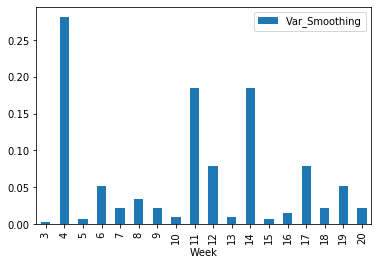

In [31]:
# Smoothing variable each week plotted in bar chart
df_out_var_smooth.plot(x='Week',y='Var_Smoothing',kind='bar')

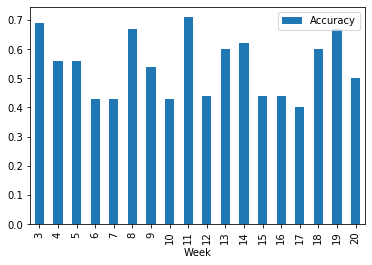

In [32]:
# Accuracy each week
df_out_acc = pred_vs_actual.groupby(['Season','Week'])['Accuracy'].mean().reset_index()
df_out_acc.plot(x='Week',y='Accuracy',kind='bar')

## Histogram of Model Probability after Cross Validation. 
    Follows a nice normal distribution. This is important for us because it gives us greater confidence in the model the farther we deviate from the mean.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ed1217c88>]],
      dtype=object)

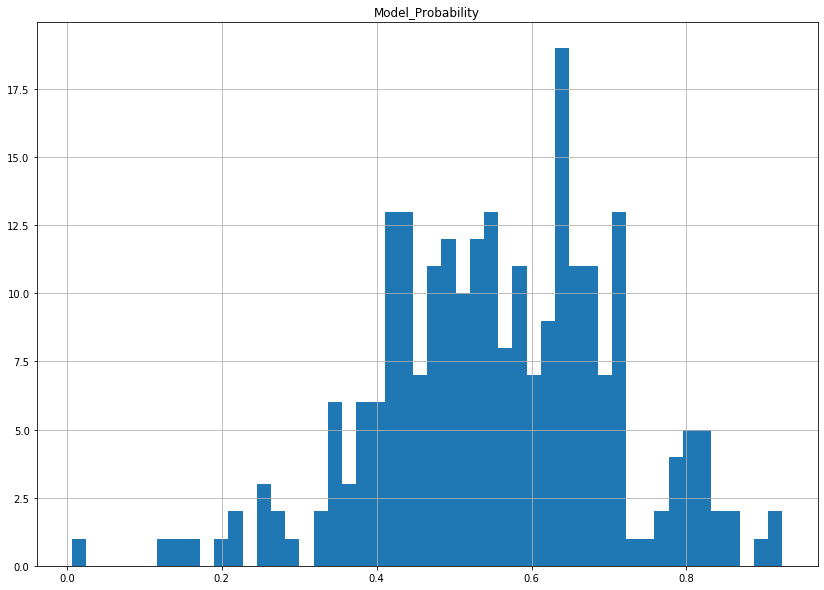

In [33]:

pred_vs_actual.hist(column='Model_Probability',bins=50,figsize=(14,10))

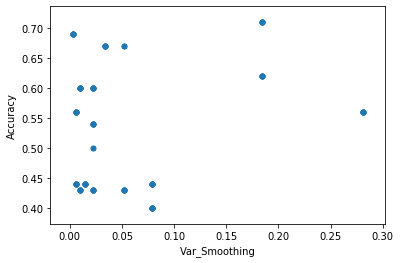

In [34]:
# Accuracy vs Smoothing Parameter
pred_vs_actual.plot(x='Var_Smoothing',y='Accuracy',kind='scatter')

## Locks for Home Team to Lose to Spread

In [35]:
# model proability greater than or equal to 70% chance for home team to beat spread.  
pp = 0.7
week_start = 2
GT_70_pct_prob = pred_vs_actual.loc[(pred_vs_actual['Model_Probability'] >= pp) 
                                 & (pred_vs_actual['Week']>week_start)  ].sort_values(by=['Model_Probability'],ascending=False).drop_duplicates()
GT_70_pct_prob.reset_index(inplace=True,drop=True)
GT_70_pct_prob.tail()

,Accuracy,Away_Team,F1_Score,Home_Team,Home_Team_Lost_Spread,Model_Probability,Precision,Prediction_Class,Recall,Season,Var_Smoothing,Week,k_best
34,0.43,Seattle Seahawks,0.30,Los Angeles Chargers,1,0.704255,0.46,1,0.86,2022,0.02223,7,12.0
35,0.43,Cincinnati Bengals,0.30,New Orleans Saints,1,0.704043,0.46,1,0.86,2022,0.05179,6,12.0
36,0.56,San Francisco 49ers,0.46,Carolina Panthers,1,0.703878,0.62,1,0.80,2022,0.00625,5,12.0
37,0.67,Denver Broncos,0.60,Jacksonville Jaguars,1,0.703820,0.62,1,1.00,2022,0.03393,8,12.0
38,0.43,Pittsburgh Steelers,0.30,Miami Dolphins,1,0.700246,0.46,1,0.86,2022,0.02223,7,12.0


In [36]:
print(GT_70_pct_prob[GT_70_pct_prob['Home_Team_Lost_Spread']==1]['Home_Team_Lost_Spread'].sum())
print(GT_70_pct_prob.shape[0])
print(round(((GT_70_pct_prob[GT_70_pct_prob['Home_Team_Lost_Spread']==1]['Home_Team_Lost_Spread'].sum())/(GT_70_pct_prob.shape[0])),2))
#GT_70_pct_prob".loc[2200:2205]

25
39
0.64


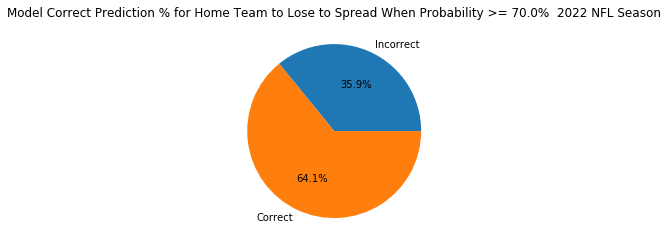

In [37]:
ypie = np.array([GT_70_pct_prob.shape[0]-
                 GT_70_pct_prob[GT_70_pct_prob['Home_Team_Lost_Spread']==1]['Home_Team_Lost_Spread'].sum(),
                GT_70_pct_prob[GT_70_pct_prob['Home_Team_Lost_Spread']==1]['Home_Team_Lost_Spread'].sum()])
fig,ax = plt.subplots()
ax.pie(ypie,labels=["Incorrect","Correct"],autopct='%1.1f%%')
plt.title(f"Model Correct Prediction % for Home Team to Lose to Spread When Probability >= {100*pp}%  2022 NFL Season")
plt.show()

In [38]:
import matplotlib.pyplot as plt
GT_70_pct_prob.groupby(['Season','Week','k_best']).Home_Team_Lost_Spread.sum() 
GT_70_pct_prob.groupby(['Season','Week','k_best']).Home_Team_Lost_Spread.count() 

df_out = GT_70_pct_prob.groupby(['Season','Week','k_best']).size().reset_index(name='count')
df_out2 = GT_70_pct_prob.groupby(['Season','Week','k_best'])['Home_Team_Lost_Spread'].sum().reset_index()
df_out['Home_Team_Lost_Spread']=df_out2['Home_Team_Lost_Spread']
df_out['HT_lose_spread_model_success%'] = 100*round((df_out['Home_Team_Lost_Spread']/df_out['count']),2)
df_out.head(10)


,Season,Week,k_best,count,Home_Team_Lost_Spread,HT_lose_spread_model_success%
0,2022,3,12.0,7,6,86.0
1,2022,4,12.0,7,4,57.0
2,2022,5,12.0,8,6,75.0
3,2022,6,12.0,6,2,33.0
4,2022,7,12.0,6,4,67.0
5,2022,8,12.0,3,2,67.0
6,2022,10,12.0,2,1,50.0


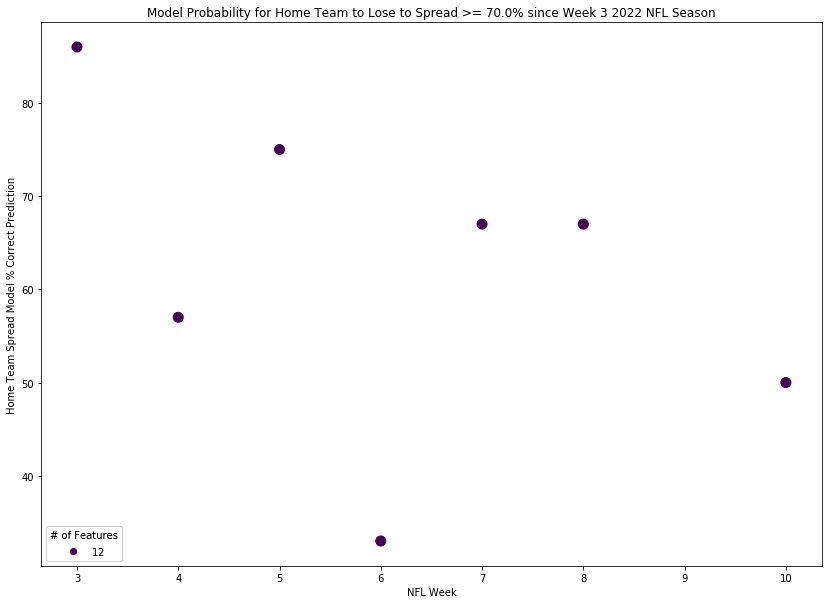

In [39]:


fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(df_out['Week'], df_out['HT_lose_spread_model_success%'],c=df_out['k_best'],s=100)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="# of Features")
ax.add_artist(legend1)



plt.xlabel('NFL Week')
plt.ylabel('Home Team Spread Model % Correct Prediction')
plt.title(f"Model Probability for Home Team to Lose to Spread >= {100*pp}% since Week {week_start+1} 2022 NFL Season")


plt.show()

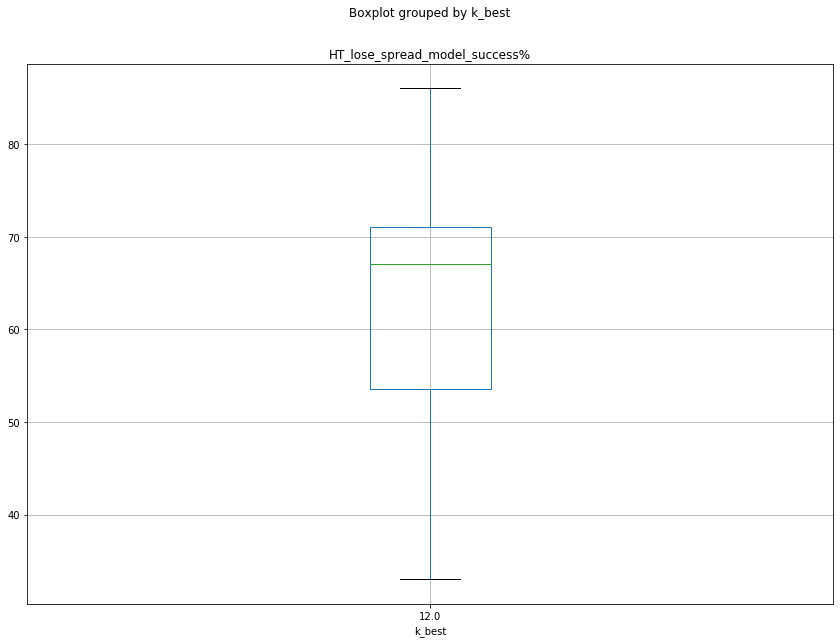

In [40]:
# Creating plot
boxplot = df_out.boxplot(column = 'HT_lose_spread_model_success%' ,by = 'k_best' , figsize = (14,10)
                      )


## Locks for Home Team to Beat Spread

In [41]:
# Model Probability for Home Team to beat spread > 75%. This means same thing as model probability being low for 
# home team to lose to spread.
ps = 0.25
week_start = 2
LT_20_pct_prob = pred_vs_actual.loc[(pred_vs_actual['Model_Probability'] <= ps) 
                                 & (pred_vs_actual['Week']>week_start)  ].sort_values(by=['Model_Probability'],ascending=False).drop_duplicates()
LT_20_pct_prob.reset_index(inplace=True,drop=True)
LT_20_pct_prob.head(50)

print(LT_20_pct_prob[LT_20_pct_prob['Home_Team_Lost_Spread']==0]['Home_Team_Lost_Spread'].count())
print(LT_20_pct_prob.shape[0])
print(round(((LT_20_pct_prob[LT_20_pct_prob['Home_Team_Lost_Spread']==0]['Home_Team_Lost_Spread'].count())/(LT_20_pct_prob.shape[0])),3))
#GT_70_pct_prob".loc[2200:2205]
LT_20_pct_prob['actual_0_count']=0
LT_20_pct_prob.loc[LT_20_pct_prob['Home_Team_Lost_Spread']==0,'actual_0_count']=1
LT_20_pct_prob.head(10)


5
7
0.714


,Accuracy,Away_Team,F1_Score,Home_Team,Home_Team_Lost_Spread,Model_Probability,Precision,Prediction_Class,Recall,Season,Var_Smoothing,Week,k_best,actual_0_count
0,0.56,Pittsburgh Steelers,0.46,Buffalo Bills,0,0.226008,0.62,0,0.80,2022,0.00625,5,12.0,1
1,0.50,Cincinnati Bengals,0.33,Buffalo Bills,1,0.216237,0.00,0,0.00,2022,0.02223,20,12.0,0
2,0.69,Buffalo Bills,0.65,Miami Dolphins,0,0.195168,0.80,0,0.73,2022,0.00268,3,12.0,1
3,0.60,Kansas City Chiefs,0.60,Cincinnati Bengals,0,0.159115,0.57,0,0.57,2022,0.00954,13,12.0,1
4,0.44,Kansas City Chiefs,0.44,Houston Texans,0,0.146141,0.43,0,0.38,2022,0.00625,15,12.0,1
5,0.69,Las Vegas Raiders,0.65,Tennessee Titans,0,0.133914,0.80,0,0.73,2022,0.00268,3,12.0,1
6,0.69,Los Angeles Rams,0.65,Arizona Cardinals,1,0.006652,0.80,0,0.73,2022,0.00268,3,12.0,0


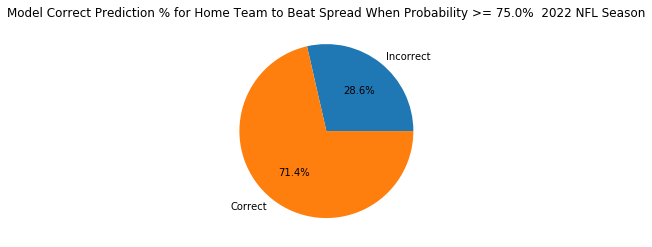

In [42]:
ypieb = np.array([LT_20_pct_prob.shape[0]-
                 LT_20_pct_prob[LT_20_pct_prob['Home_Team_Lost_Spread']==0]['Home_Team_Lost_Spread'].count(),
                LT_20_pct_prob[LT_20_pct_prob['Home_Team_Lost_Spread']==0]['Home_Team_Lost_Spread'].count()])
fig,ax = plt.subplots()
ax.pie(ypieb,labels=["Incorrect","Correct"],autopct='%1.1f%%')
plt.title(f"Model Correct Prediction % for Home Team to Beat Spread When Probability >= {100*(1-ps)}%  2022 NFL Season")
plt.show()

In [43]:
import matplotlib.pyplot as plt
#LT_20_pct_prob.groupby(['Season','Week','k_best']).Home_Team_Lost_Spread.sum() 
#LT_20_pct_prob.groupby(['Season','Week','k_best']).Home_Team_Lost_Spread.count() 

df_out_L = LT_20_pct_prob.groupby(['Season','Week','k_best']).size().reset_index(name='count')
df_out2_L = LT_20_pct_prob.groupby(['Season','Week','k_best'])['actual_0_count'].sum().reset_index()
df_out_L['Home_Team_Beat_Spread']=df_out2_L['actual_0_count']
df_out_L['HT_Beat_spread_model_success%'] = 100*round((df_out_L['Home_Team_Beat_Spread']/df_out_L['count']),2)
df_out_L.head(10)

,Season,Week,k_best,count,Home_Team_Beat_Spread,HT_Beat_spread_model_success%
0,2022,3,12.0,3,2,67.0
1,2022,5,12.0,1,1,100.0
2,2022,13,12.0,1,1,100.0
3,2022,15,12.0,1,1,100.0
4,2022,20,12.0,1,0,0.0


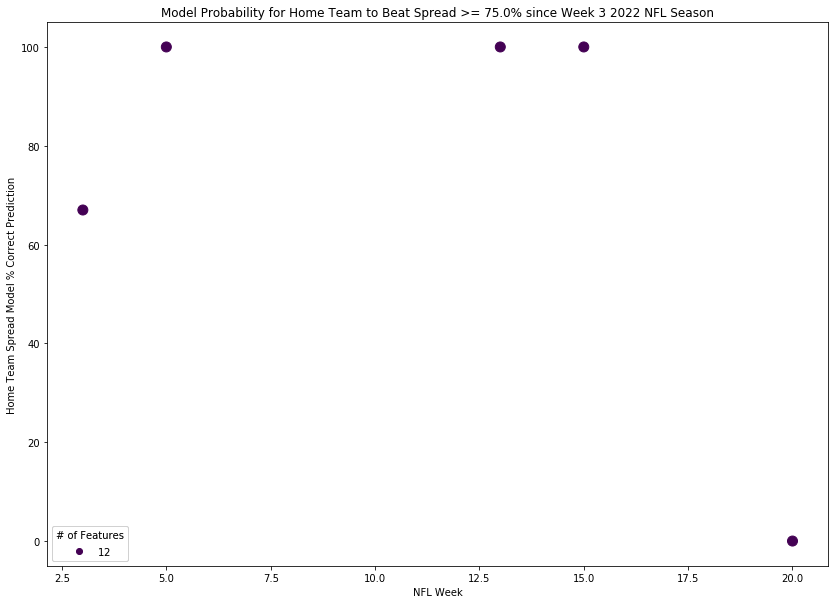

In [44]:
fig, ax = plt.subplots(figsize=(14, 10))
#fig.figure(figsize=(14, 10))
scatter = ax.scatter(df_out_L['Week'], df_out_L['HT_Beat_spread_model_success%'],c=df_out_L['k_best'],s=100)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="# of Features")
ax.add_artist(legend1)

# produce a legend with a cross-section of sizes from the scatter
#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.2)
#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.xlabel('NFL Week')
plt.ylabel('Home Team Spread Model % Correct Prediction')
plt.title(f"Model Probability for Home Team to Beat Spread >= {100*(1-ps)}% since Week {week_start+1} 2022 NFL Season")


plt.show()

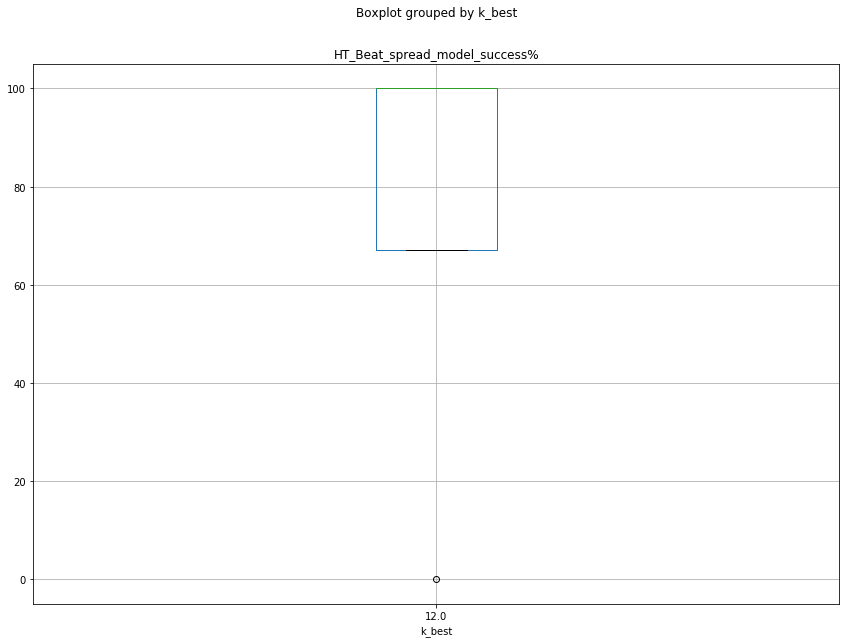

In [45]:
boxplot = df_out_L.boxplot(column = 'HT_Beat_spread_model_success%' ,by = 'k_best' , figsize = (14,10))

## Feature Importances Matrix for Different Weeks

In [46]:
top_feats.head(25)

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12
1,passing_interception_percentage,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_team
2,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_team,team_name
3,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_def_yards_per_play,home_punts,team_name
4,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,away_pass_int_pct,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
5,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
6,passing_interception_percentage,passing_first_downs_earned,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,team_name
7,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
8,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
9,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,rushing_yards_per_attempt,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,home_punts,away_team,team_name
10,passing_interception_percentage,third_down_conversions_percentage,fourth_down_attempts,penalties_committed_yards,opponent_penalties_committed_yards,away_passing_first_downs_earned,away_third_downs_convs_pct,away_fourth_down_attempts,away_punts,home_punts,away_team,team_name


In [47]:
df2 = pd.unique(top_feats[['feat1', 'feat2',
                          'feat3','feat4','feat5','feat6',
                          'feat7','feat8','feat9','feat10','feat11','feat12']].values.ravel())
print(df2)

['passing_interception_percentage' 'passing_first_downs_earned'
 'third_down_conversions_percentage' 'fourth_down_attempts'
 'penalties_committed_yards' 'opponent_penalties_committed_yards'
 'rushing_yards_per_attempt' 'away_pass_int_pct'
 'away_passing_first_downs_earned' 'away_third_downs_convs_pct'
 'away_fourth_down_attempts' 'away_team' 'team_name'
 'away_def_yards_per_play' 'home_punts' 'away_punts']


In [48]:
# count up each feature and see how many times it is in the feature importance list. Feat 1 would be the select K best most 
# important feature and Feat 12 would be 12th most important. 
consolidate = top_feats.apply(pd.Series.value_counts)
consolidate = consolidate.replace(np.nan,0) 
consolidate

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12
away_def_yards_per_play,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
away_fourth_down_attempts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0,2.0,1.0,0.0
away_pass_int_pct,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
away_passing_first_downs_earned,0.0,0.0,0.0,0.0,0.0,5.0,10.0,2.0,1.0,0.0,0.0,0.0
away_punts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
away_team,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,6.0
away_third_downs_convs_pct,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0,2.0,1.0,0.0,0.0
fourth_down_attempts,0.0,0.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
home_punts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,0.0
opponent_penalties_committed_yards,0.0,0.0,0.0,3.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#make easier to read with color
consolidate.style.background_gradient(cmap ='coolwarm')

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12
away_def_yards_per_play,0,0,0,0,0,0,0,0,2,1,0,0
away_fourth_down_attempts,0,0,0,0,0,0,0,5,10,2,1,0
away_pass_int_pct,0,0,0,0,0,2,1,1,0,0,0,0
away_passing_first_downs_earned,0,0,0,0,0,5,10,2,1,0,0,0
away_punts,0,0,0,0,0,0,0,0,3,5,0,0
away_team,0,0,0,0,0,0,0,0,0,0,10,6
away_third_downs_convs_pct,0,0,0,0,0,0,5,10,2,1,0,0
fourth_down_attempts,0,0,16,2,0,0,0,0,0,0,0,0
home_punts,0,0,0,0,0,0,0,0,0,9,7,0
opponent_penalties_committed_yards,0,0,0,3,13,2,0,0,0,0,0,0


In [50]:
if(connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed
